In [1]:
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install -q transformers

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.experimental import RMSprop


2023-08-08 23:22:01.711523: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 23:22:01.748712: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 23:22:01.749954: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 23:22:02.543322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/unix_blamb/.pyenv/versions/3.10.6/envs/vino_verdict/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the dataset
wine_df = pd.read_csv('../cleaned_wine_df.csv')

# Shuffle the dataset
wine_df_sample = wine_df.sample(frac=1).reset_index(drop=True)

# Function to adjust the scale of 'points' data
def points_to_scale(points, scale=5):
    points_norm = (points - np.min(points)) / (np.max(points) - np.min(points))
    scaled_points = np.round(points_norm * (scale-1) + 1).astype(int)  # Adjust to scale-1
    return np.where(scaled_points > scale-1, scale, scaled_points)  # Ensure the max is 'scale'

# Apply transformation to points
wine_df_sample['points'] = points_to_scale(wine_df_sample['points'])

# Display the first few rows of the dataframe
wine_df_sample.head()

,country,description,points,price,province,region_1,title,variety,winery,year
0,US,"A barrel-selection, top-of-the-line cuvée, thi...",4,75.0,Oregon,Eola-Amity Hills,Bethel Heights 2015 Casteel Pinot Noir (Eola-A...,Pinot Noir,Bethel Heights,2015
1,US,"Mandarin orange Creamsicle, Cool Whip with van...",4,60.0,California,Santa Cruz Mountains,Thomas Fogarty 2012 Damiana Vineyard Chardonna...,Chardonnay,Thomas Fogarty,2012
2,US,The aromas are redolent with notes of blueberr...,3,37.0,Washington,Walla Walla Valley (WA),L'Ecole No. 41 2013 Estate Grown Seven Hills V...,Syrah,L'Ecole No. 41,2013
3,Argentina,"Dark and incredibly concentrated, with earth, ...",4,100.0,Mendoza Province,Mendoza,Monteviejo 2007 Lindaflor La Violeta Malbec (M...,Malbec,Monteviejo,2007
4,US,From four vineyard sites across the appellatio...,4,60.0,California,Sonoma Coast,Della 2015 Pinot Noir (Sonoma Coast),Pinot Noir,Della,2015


In [4]:
wine_df_sample['points'].value_counts()

points
3    57948
2    42931
4    11887
1     2711
5      125
Name: count, dtype: int64

In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def build_transformer_model(input_shape):
    distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
    input_ids = Input(shape=input_shape, dtype='int32')
    outputs = distilbert_model(input_ids)
    # Extract embeddings corresponding to the [CLS] token
    cls_token_embedding = outputs[0][:, 0, :]
    x = Dense(10, activation='relu')(cls_token_embedding)
    output = Dense(1, activation='linear')(x)
    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizer=RMSprop(), loss='mean_squared_error', 
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredLogarithmicError()])
    return model

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

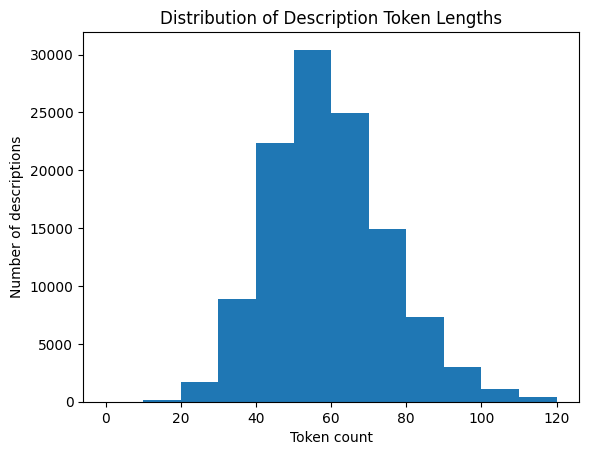

In [7]:
# Tokenize descriptions and compute their lengths
token_lens = [len(tokenizer.encode(txt, max_length=128, truncation=True)) for txt in wine_df_sample.description]

# Optionally, visualize the distribution of token lengths
import matplotlib.pyplot as plt
plt.hist(token_lens, bins=range(0, 130, 10))
plt.xlabel('Token count')
plt.ylabel('Number of descriptions')
plt.title('Distribution of Description Token Lengths')
plt.show()

In [8]:
# Set the maximum token length based on the distribution observed in the previous cell
MAX_LEN = 128

In [9]:
# Split the data into training and validation sets
# Stratify to ensure the distribution of points remains similar in both sets
X_train, X_val, y_train, y_val = train_test_split(wine_df_sample.index.values, 
                                                  wine_df_sample.points.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=wine_df_sample.points.values)

In [10]:
# Label each row in the dataframe as either 'train' or 'val' based on the split
wine_df_sample['data_type'] = ['not_set']*wine_df_sample.shape[0]
wine_df_sample.loc[X_train, 'data_type'] = 'train'
wine_df_sample.loc[X_val, 'data_type'] = 'val'

In [11]:
# Tokenize and encode the training data
encoded_data_train = tokenizer.batch_encode_plus(
    wine_df_sample[wine_df_sample.data_type=='train'].description.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    truncation=True,
    max_length=MAX_LEN, 
    return_tensors='tf'
)

# Tokenize and encode the validation data
encoded_data_val = tokenizer.batch_encode_plus(
    wine_df_sample[wine_df_sample.data_type=='val'].description.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    truncation=True,
    max_length=MAX_LEN, 
    return_tensors='tf'
)

# Extract input IDs, attention masks, and labels for training sets
input_ids_train = np.array(encoded_data_train['input_ids'])
attention_masks_train = np.array(encoded_data_train['attention_mask'])
labels_train = np.array(wine_df_sample[wine_df_sample.data_type=='train'].points.values)  # or however you've stored the labels

# Extract input IDs, attention masks, and labels for validation sets
input_ids_val = np.array(encoded_data_val['input_ids'])
attention_masks_val = np.array(encoded_data_val['attention_mask'])
labels_val = np.array(wine_df_sample[wine_df_sample.data_type=='val'].points.values)  # or however you've stored the labels

2023-08-08 23:25:33.323264: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (100)


In [12]:
print("Training shapes:")
print(input_ids_train.shape)
print(attention_masks_train.shape)
print(labels_train.shape)

print("\nValidation shapes:")
print(input_ids_val.shape)
print(attention_masks_val.shape)
print(labels_val.shape)

Training shapes:
(98261, 128)
(98261, 128)
(98261,)

Validation shapes:
(17341, 128)
(17341, 128)
(17341,)


In [13]:
# Create TensorFlow datasets for training and validation
dataset_train = tf.data.Dataset.from_tensor_slices((input_ids_train, attention_masks_train, labels_train)).shuffle(10000).batch(64)
dataset_val = tf.data.Dataset.from_tensor_slices((input_ids_val, attention_masks_val, labels_val)).batch(64)

In [14]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=10, 
    verbose=1,
    restore_best_weights=True
)

# Build the model
model = build_transformer_model((128,))  # Ensure this model is suitable for your task

# Train the model with the early stopping callback
history = model.fit(
    input_ids_train,  # You only pass input ids based on the model structure
    labels_train, 
    epochs=50,
    batch_size=4,
    validation_data=(input_ids_val, labels_val),
    callbacks=[early_stopping]
)

# Evaluate the model
evaluation_results = model.evaluate(input_ids_val, labels_val)
print(f"Validation Loss: {evaluation_results[0]}")
print(f"Validation Metrics: {evaluation_results[1:]}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/50
  944/24566 [>.............................] - ETA: 7:02:57 - loss: 0.7975 - root_mean_squared_error: 0.8930 - mean_squared_logarithmic_error: 0.0571

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# In the model.compile(), you can include this in metrics as follows:

model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=[r_squared])


In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_pad, y_test_oh)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
from sklearn.metrics import classification_report

# Make predictions
y_pred = model.predict(X_test_pad)

# Convert prediction probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(y_test, y_pred_classes))